# Brief overview

[Open Glider Network](https://www.glidernet.org/) (OGN) is an open source project that powers ground stations capable of receiving aircraft locations and relaying them over the internet. Data is freely available for any one to stream by connecting to the appropriate APRS servers.


## Data and methods

The data used in this analysis was collected between 2017-08-09	and 2018-05-19 using the [ogn-lib](https://github.com/akolar/ogn-lib) package. On 2018-05-20 OGN introduced [new data usage rules](https://www.glidernet.org/ogn-data-usage/), which effectively prohibit performing any kind of data manipulation after 24 hours have passed since its collection, therefore any data collected after this date is not included in this document. Also keep in mind that some days are missing due to technical difficulties on the clients side.

Size of the exported database is 80 GB (CSV without compression). For the purposes of this analysis the data was uploaded and stored on an Amazon Redshift cluster. Returned aggregates were further processed using pandas and visualized with either matplotlib or seaborn. 

A record received from OGN (usually -- not all receivers provide all the fields) contains the following information:

- device ID
- receiver ID
- timestamp
- latitude and longitude
- ground speed
- heading
- altitude
- vertical speed

An example of such record is

```
FLRDDFB2A>APRS,qAS,LFPF:/181325h4849.83N\00204.65E^292/072/A=001115 !W66! id22DDFB2A +040fpm +0.0rot 10.2dB 0e -6.7kHz gps2x3
```

In the remainder of this notebook we will dive into available information a bit further.

# Imports and helper functions

In [1]:
%matplotlib inline

In [2]:
import calendar
import colorsys
import enum
import hashlib
import json
import logging
import os
import pickle
import time
from datetime import date

import gmaps
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

sns.set_style('whitegrid')

# Load GMaps access key
with open('./gmaps_key.txt', 'r') as f:
    gmaps.configure(f.read().strip())

# Load database url
with open('./db_url.txt', 'r') as f:
    db_url = f.read().strip()
engine = sqlalchemy.create_engine(db_url)

In [3]:
# Weekday id -> Weekday name
WEEKDAYS = dict(enumerate(calendar.day_name))

# Glider type name <--> Glider type id
TYPE_TO_ID = dict(unknown=0, glider=1, tow_plane=2, helicopter_rotorcraft=3, parachute=4,
                  drop_plane=5, hang_glider=6, paraglider=7, powered_aircraft=8,
                  jet_aircraft=9, ufo=10, baloon=11, airship=12, uav=13, static_object=15)
ID_TO_TYPE = {v: k for k, v in TYPE_TO_ID.items()}

In [4]:
def ttime(fn):
    """Times the execution of the wrapped function and logs the execution time."""
    
    def wrapper(*args, **kwargs):
        start = time.time()
        
        ret = fn(*args, **kwargs)
        
        elapsed = time.time() - start
        logger.info('Execution of {} took {:.03f} s'.format(fn.__name__, elapsed))
        
        return ret
    
    return wrapper

In [5]:
def get_from_cache(name):
    """Retrieves data from cache or raises FileNotFoundError if cache file is not found.
    
    :param str name: cache file name
    :return: cached content
    """

    with open(os.path.join('./cache', name), 'rb') as f:
        return pickle.load(f)


def save_to_cache(name, data):
    """Stores the data to a cache file overwriting any previous content.
    
    :param str name: cache file name
    :param data: data of arbitrary type to be cached
    """
    
    with open(os.path.join('./cache', name), 'wb') as f:
        pickle.dump(data, f)

@ttime
def execute_query(query, params={}, with_={}):
    """
    Returns a locally cached result of the query or fetches the result from Redshift.
    Assumes that the data on the remote server is static (i.e. does not change between queries).
    
    :params str query: SQL query
    :param dict params: query parameters to be passed along to sqlalchemy
    :param dict with_: a dict of aditional WITH statements to be executed before the main query
    """
    
    name = hashlib.sha1((query + json.dumps(params) + json.dumps(with_)).encode()).hexdigest()
    name += '.pickle'
    
    try:
        cached_data = get_from_cache(name)
        logger.info('Loaded from cache')
        return cached_data
    except FileNotFoundError:
        logger.info('Cache file not found. Fetching results from redshift')

    if with_:
        with_statements = ['{} AS ({})'.format(k, v) for k, v in with_.items()]
        full_query = 'WITH {}\n{}'.format(','.join(with_statements), query)
    else:
        full_query = query

    data = pd.read_sql_query(full_query, engine, params=params)
    save_to_cache(name, data)
    return data

# Dataset

The following queries show the basic attributes of the analysed data.

In [6]:
n_records = execute_query('''
SELECT
    COUNT(*) as total, 
    (SELECT COUNT(*) as europe FROM record
     WHERE latitude BETWEEN 36.0 AND 70.0 AND longitude BETWEEN -14.0 AND 42.0) as europe
FROM record;''')
n_records['row'] = n_records.total - n_records.europe

n_flarms = execute_query('''SELECT COUNT(DISTINCT flarm_id) as n_flarms FROM flarm;''')
n_receivers = execute_query('''SELECT COUNT(DISTINCT name) as n_flarms FROM receiver;''')

INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.002 s
INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.002 s
INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.003 s


In [7]:
n_records

,total,europe,row
0,870001165,822350236,47650929


In [8]:
n_flarms

,n_flarms
0,54116


In [9]:
n_receivers

,n_flarms
0,1951


There is a total of 870,001,165 records in our database. Those were sent out from 54,116 different (FLARM) devices and received by 1951 unique receivers.

# Records by aircraft types

INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.002 s


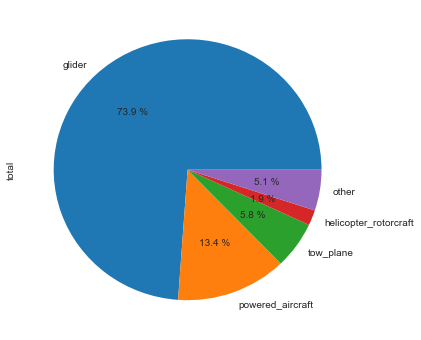

In [10]:
act_count = execute_query('''
SELECT
    aircraft_type as type,
    COUNT(*) as total
FROM record
GROUP BY type;''')

act_count.type.replace(ID_TO_TYPE, inplace=True)
act_count.set_index(['type'], inplace=True)
act_count.sort_values(by='total', inplace=True, ascending=False)

small_values = act_count.total / act_count.total.sum() < 0.015
sum_other = act_count[small_values].total.sum()
act_count.drop(index=act_count.index[small_values], inplace=True)
act_count.loc['other', 'total'] = sum_other

act_count.total.plot.pie(legend=None, figsize=(6, 6), autopct='%.1f %%')

In [11]:
act_count

,total
type,
glider,642622011.0
powered_aircraft,116312965.0
tow_plane,50630643.0
helicopter_rotorcraft,16473601.0
other,43961945.0


A majority (73.9 %) of those records were produced by devices identifying themselves as gliders. Other aircraft types worth mentioning are powered aircrafts (13.4 %, e.g. single motor aircrafts), tow planes (5.8 %) and helicopters/rotorcrafts (1.9 %).

# Records by location

([<matplotlib.patches.Wedge at 0x7fcd1afca9b0>,
 [Text(-1.08376,0.188343,'Europe'),
  Text(1.08376,-0.188343,'Rest of the world')],
 [Text(-0.59114,0.102732,'94.5 %'), Text(0.59114,-0.102732,'5.5 %')])

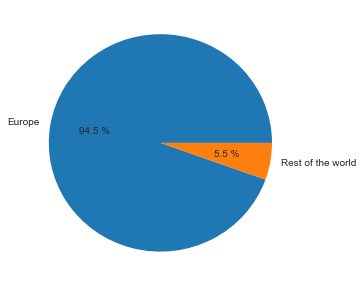

In [12]:
plt.figure(figsize=(5,5))
plt.pie([n_records.europe[0], n_records.row[0]], labels=['Europe', 'Rest of the world'], autopct='%.01f %%', )

Almost all (94.5 %) records are sent out by devices located in Europe.

# Records per year

In [13]:
records_by_year = execute_query('''
SELECT extract(year from timestamp) as year, COUNT(*) as total
FROM record
GROUP BY year;''')

INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.002 s


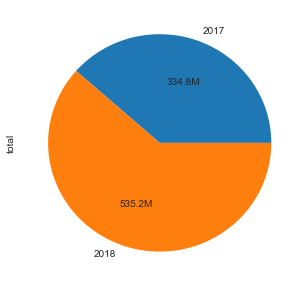

In [14]:
records_by_year.plot.pie(x='year', y='total', labels=records_by_year.year, legend=None, figsize=(5, 5),
                         autopct=lambda x: '{:.01f}M'.format(x * records_by_year.total.sum() / 1e8))

# Daily distribution

In [15]:
rec_per_day = execute_query('''
SELECT date_trunc('day', timestamp) as date, COUNT(*) as total, COUNT(DISTINCT flarm) as n_devices
FROM record
GROUP BY date;''')
rec_per_day.date = pd.to_datetime(rec_per_day.date)
rec_per_day.sort_values(by='date', inplace=True)
rec_per_day['date_only'] = rec_per_day.date.dt.date
rec_per_day['year'] = rec_per_day.date.dt.year
rec_per_day['week'] = rec_per_day.date.dt.week

INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.002 s


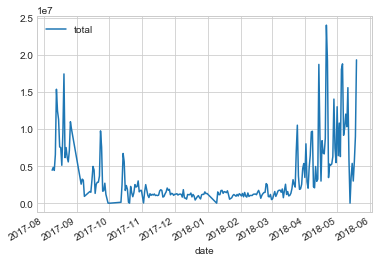

In [16]:
rec_per_day.plot.line(x='date', y='total', )

The plot above shows the number of records captured each day.

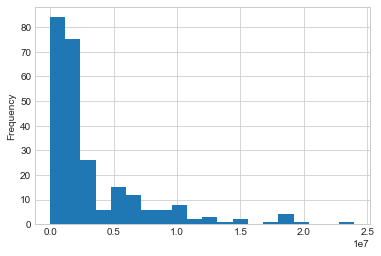

In [17]:
rec_per_day.plot.hist(y='total', bins=20, legend=None)

As observable from the plot above, most days are pretty mediocre: on most days the number of received records was below 5 million. Days with more than 10 million records are rare (19 out of 253 days).

# Best days

Text(0.5,0,'# of distinct devices')

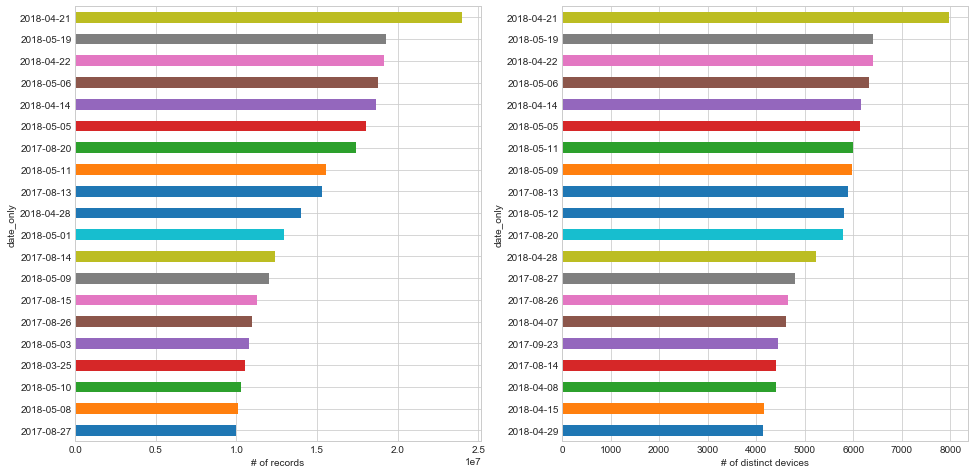

In [18]:
best_days = rec_per_day.sort_values(by='total', ascending=False).head(20).sort_values('total')
best_days['date_only'] = best_days.date.dt.date
best_days['weekday'] = best_days.date.dt.weekday

most_devices = rec_per_day.sort_values(by='n_devices', ascending=False).head(20).sort_values('n_devices')
most_devices['date_only'] = most_devices.date.dt.date
most_devices['weekday'] = most_devices.date.dt.weekday

f, axes = plt.subplots(1, 2, figsize=(16, 8))
best_days.plot.barh(x='date_only', y='total', legend=None, ax=axes[0])
axes[0].set_xlabel('# of records')
most_devices.plot.barh(x='date_only', y='n_devices', legend=None, ax=axes[1])
axes[1].set_xlabel('# of distinct devices')

The plot above shows 20 best days in terms of number of received records (left) and number of unique devices (right).

In [19]:
best_weekday = best_days.groupby(by=['weekday'])['total'].count()

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

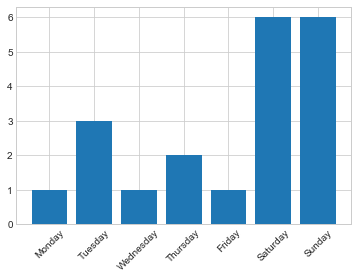

In [20]:
plt.bar(WEEKDAYS.values(), best_weekday.values)
plt.xticks(rotation=45)

Obviously people mostly visit airports on weekends.

In [21]:
best_days[~best_days.weekday.isin([5, 6])]

,date,total,n_devices,date_only,year,week,weekday
126,2018-05-08,10089913,2980,2018-05-08,2018,19,1
127,2018-05-10,10299698,3447,2018-05-10,2018,19,3
246,2018-05-03,10788874,2647,2018-05-03,2018,18,3
137,2017-08-15,11273238,3663,2017-08-15,2017,33,1
248,2018-05-09,11997070,5973,2018-05-09,2018,19,2
1,2017-08-14,12406007,4413,2017-08-14,2017,33,0
245,2018-05-01,12984316,4010,2018-05-01,2018,18,1
249,2018-05-11,15555345,5998,2018-05-11,2018,19,4


Some of the popular weekdays also happended to be on or around national holiday (e.g. 1st and 3rd May, 14th and 15th Aug).

# Relative hourly distribution

In [22]:
rec_per_hour = execute_query('''
SELECT date_trunc('hour', timestamp) as day_hour, COUNT(*) as total
FROM record
GROUP BY day_hour;''')
rec_per_hour['timestamp'] = pd.to_datetime(rec_per_hour.day_hour)
rec_per_hour['date_only'] = rec_per_hour.timestamp.dt.date
rec_per_hour['hour'] = rec_per_hour.timestamp.dt.hour
rec_per_hour.drop('day_hour', axis=1, inplace=True)
rec_per_hour = pd.merge(rec_per_hour, rec_per_day, on='date_only', suffixes=['_hourly', '_daily'])
rec_per_hour.drop(['date', 'timestamp'], axis=1, inplace=True)
rec_per_hour.columns = ['total_hour', 'date', 'hour', 'total_day', 'n_devices', 'year', 'week']
rec_per_hour['perc'] = rec_per_hour.total_hour / rec_per_hour.total_day

INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.003 s


In [23]:
# Drop days with records for less than 20 different hours (when logging system was offline)
missing_hours = rec_per_hour.groupby('date')['total_hour'].count() < 20
drop_idx = rec_per_hour.index[rec_per_hour.date.isin(missing_hours.iloc[missing_hours.nonzero()[0]].index)]
rec_per_hour.drop(index=drop_idx, inplace=True)

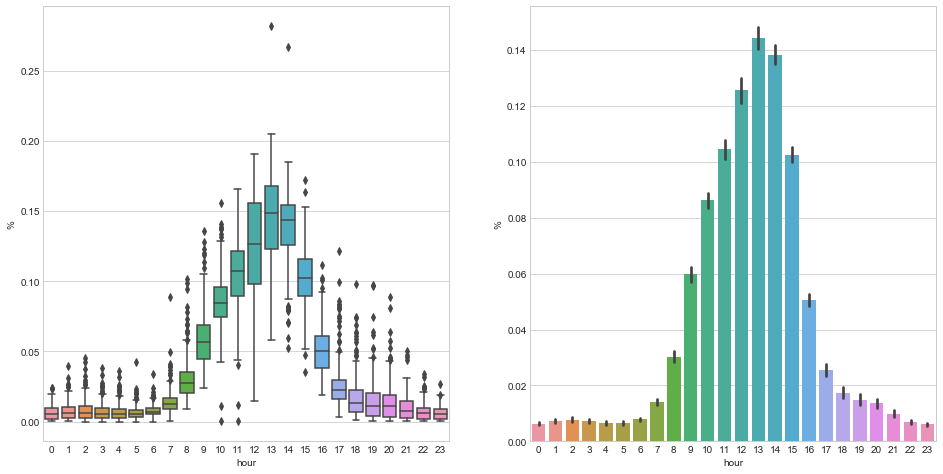

In [24]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.boxplot(x=rec_per_hour.hour, y=rec_per_hour.perc, ax=axes[0])
sns.barplot(x=rec_per_hour.hour, y=rec_per_hour.perc, ax=axes[1])
for a in axes:
    a.set(xlabel='hour', ylabel='%')

In [25]:
rec_per_hour.groupby('hour').mean().loc[10:15, 'perc'].sum()

0.7018736153755011

Hourly distribution of the records closely resembles normal distribution with the mean around 13 hours UTC; a majority of flights (70.2 %) occurs between 10 and 15 UTC, giving us an estimate for the deviation: ~2 hours.

In [26]:
rec_per_hour.loc[rec_per_hour.total_hour.idxmax()]

total_hour       4033451
date          2018-04-21
hour                  13
total_day       23977693
n_devices           7966
year                2018
week                  16
perc            0.168217
Name: 5168, dtype: object

Most messages in one hours were received on 2018-04-21 (which isn't totally coincidently, since this is also the most popular day) when 4.03M messages were processed; which is an averages to about 1120 messages/second.

# Weekday distribution

In [27]:
rec_per_week = execute_query('''
SELECT date_part('year', timestamp) as year, date_part('week', timestamp) as week, COUNT(*) as total
FROM record
GROUP BY year, week;''')

INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.002 s


In [28]:
rec_day_week = pd.merge(rec_per_day, rec_per_week, on=['year', 'week'], suffixes=['_daily', '_weekly'])
rec_day_week['perc'] = rec_day_week.total_daily / rec_day_week.total_weekly
rec_day_week['dow'] = rec_day_week.date.dt.weekday

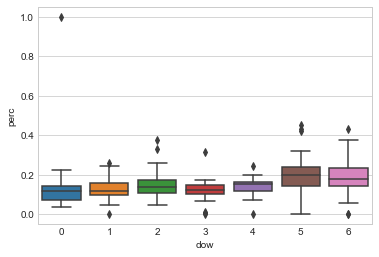

In [29]:
sns.boxplot(x=rec_day_week.dow, y=rec_day_week.perc)

Records per day are evenly distributed with the average of about 15%. Weekend is slightly more active than the other days; Saturday and Sunday account for about 40% of weekly traffic. 

# Heatmap

In [30]:
def agr_to_geojson(data, bins_per_deg, color_fn=lambda x: x):
    """Converts the aggregated data to GeoJson
    
    :param data: pandas dataframe
    :param int bins_per_deg: number of bins that one degree is devided into
    :parma color_fn: function to be applied over the aggregated value
    :return: geojson
    """
    
    box_delta = 1 / bins_per_deg
    
    df = data.copy()
    df['lat_max'] = df.lat_min + box_delta
    df['lon_max'] = df.lon_min + box_delta
    
    max_val = df.value.max()
    df['color_ratio'] = df.value.apply(color_fn)
    df['color_ratio'] /= df.color_ratio.max()
    
    features = []
    colors = []
    for i, r in df.iterrows():
        features.append({
            'type': 'Feature',
            'geometry': {
                'type': 'Polygon',
                'coordinates': [[
                    [r.lon_min, r.lat_max],
                    [r.lon_max, r.lat_max],
                    [r.lon_max, r.lat_min],
                    [r.lon_min, r.lat_min],
                    [r.lon_min, r.lat_max]
                ]]
            }
        })
        
        colors.append(mpl.colors.to_hex(mpl.cm.inferno(r.color_ratio)))

    return {'type': 'FeatureCollection', 'features':features}, colors

In [ ]:
bins_per_deg = 8
bin_delta = 1 / bins_per_deg

pos_heatmap = execute_query('''
SELECT 
    lat_min, lon_min, COUNT(*) as value
FROM (
    SELECT
        round(latitude * %(bins)s) / %(bins)s as lat_min, round(longitude * %(bins)s) / %(bins)s as lon_min,
        *
    FROM record
)
WHERE 
    lat_min BETWEEN 36.0 AND 70.0 AND
    lon_min BETWEEN -14.0 AND 42.0
GROUP BY lat_min, lon_min;''', params={'bins': bins_per_deg})
pos_heatmap = pd.DataFrame(pos_heatmap.groupby(['lat_min', 'lon_min'])['value'].sum())  # group -0 and 0
pos_heatmap.reset_index(level=pos_heatmap.index.names, inplace=True)

geojson, colors = agr_to_geojson(pos_heatmap, bins_per_deg, color_fn=np.log)
fig = gmaps.Map()
layer = gmaps.geojson_layer(geojson, fill_color=colors, fill_opacity=0.65, stroke_weight=0.0)
fig.add_layer(layer)
fig

INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.002 s


![.](heatmap.png)

The heatmap above shows that the most popular are in the Alps, Central/Southern Germany, and in the South of the UK. There are almost no flights over some of the larger cities.

Note: Generated GMaps objects do not persist over different jupyter sessions, therefore the image above is static.

# Total duration of the recorded data

In [74]:
MISSING_DELTA = 2
IDLE_DELTA = 3 * 60

DELTAS = '''
SELECT 
    "timestamp", flarm, 
    (timestamp - lag(timestamp) OVER (PARTITION BY flarm ORDER BY timestamp)) as dtime
FROM record'''

In [75]:
recorded = execute_query('''
SELECT SUM(dtime) as total
FROM deltas
WHERE dtime < '%(missing_delta)s minutes';''', 
              params={'missing_delta': MISSING_DELTA}, with_={'deltas': DELTAS})

missing = execute_query('''
SELECT SUM(dtime) as total
FROM deltas
WHERE dtime BETWEEN '%(missing_delta)s minutes' AND '%(idle_delta)s minutes';''', 
              params={'missing_delta': MISSING_DELTA, 'idle_delta': IDLE_DELTA}, with_={'deltas': DELTAS})

rec_time = pd.concat([recorded, missing])
rec_time.index = ['recorded', 'missing']

INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.002 s
INFO:__main__:Loaded from cache
INFO:__main__:Execution of execute_query took 0.002 s


In [92]:
rec_time

,total
recorded,32823 days 05:29:31.467485
missing,20123 days 13:49:08.929443


([<matplotlib.patches.Wedge at 0x7f6b0f917cf8>,
 [Text(-0.404707,1.02285,'Recorded'), Text(0.404707,-1.02285,'Missing')],
 [Text(-0.220749,0.557916,'62.0 %'), Text(0.220749,-0.557916,'38.0 %')])

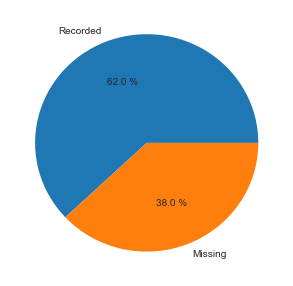

In [93]:
plt.figure(figsize=(5,5))
plt.pie(rec_time.total, labels=['Recorded', 'Missing'], autopct='%.01f %%', )

Duration of all the recorded flights is 32,823 days (approx. 89.9 years). There is also for 20,124 days worth (approx. 55.1 days) of missing segments in those flights.